# Generate and save perplexities

In [1]:
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch
import math

# Load model and tokenizer
model_name = "meta-llama/Llama-3.2-3B-Instruct"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name, device_map="auto")
# If no pad token is set, reuse the EOS token
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token
    tokenizer.pad_token_id = tokenizer.eos_token_id

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [2]:
import sys
import os
sys.path.append(os.path.abspath(".."))
from get_activations.utils import load_jsonl_data, format_prompts_from_pairs

human_list_on, assistant_list_on, full_list_on = load_jsonl_data("../data/refusal/on_policy_balanced_5k.jsonl")
human_list_off, assistant_list_off, full_list_off = load_jsonl_data("../data/refusal/off_policy_balanced_5k.jsonl")

In [3]:
from probe_gen.analysis import calculate_response_perplexities_sequentially

perplexities_on = calculate_response_perplexities_sequentially(model, tokenizer, human_list_on, assistant_list_on, verbose=True)
perplexities_off = calculate_response_perplexities_sequentially(model, tokenizer, human_list_off, assistant_list_off, verbose=True)

processing response 0
processing response 500
processing response 1000
processing response 1500
processing response 2000
processing response 2500
processing response 3000
processing response 3500
processing response 4000
processing response 4500
processing response 0
processing response 500
processing response 1000
processing response 1500
processing response 2000
processing response 2500
processing response 3000
processing response 3500
processing response 4000
processing response 4500


In [ ]:
from probe_gen.analysis import save_perplexities

save_perplexities(perplexities_on, 'llama_3b', 'refusal_5k_on')
save_perplexities(perplexities_off, 'llama_3b', 'refusal_5k_off')

# Load and visualize perplexities

In [1]:
from probe_gen.analysis import load_perplexities

perplexities_on_loaded = load_perplexities('llama_3b', 'refusal_5k_on')
perplexities_off_loaded = load_perplexities('llama_3b', 'refusal_5k_off')

wandb: ERROR Failed to detect the name of this notebook. You can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: samdower to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  


In [2]:
import numpy as np

def filter_out_nans(data):
    arr = np.array(data)
    arr = arr[np.isfinite(arr)]
    return arr

perplexities_on_loaded = filter_out_nans(perplexities_on_loaded)
perplexities_off_loaded = filter_out_nans(perplexities_off_loaded)

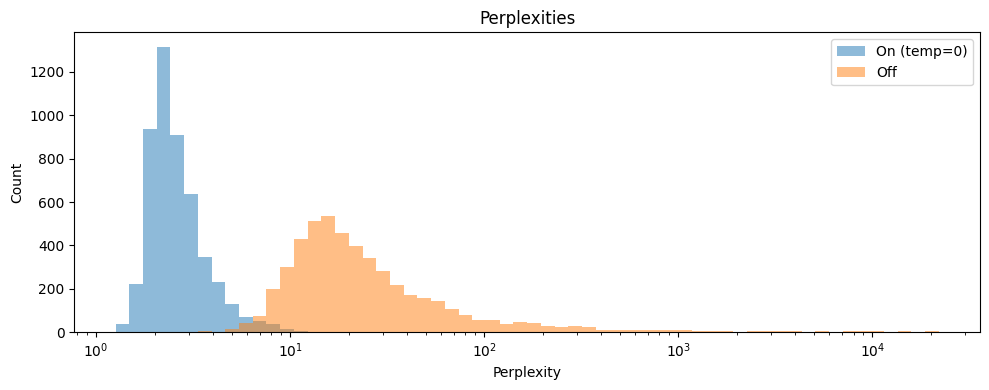

In [6]:
from probe_gen.analysis import plot_perplexities

plot_perplexities([perplexities_on_loaded, perplexities_off_loaded], ['On (temp=0)', 'Off'], remove_outliers=True, num_bins=60)